In [61]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline, classification, pipeline, evaluation
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Part 2

We will try to detect spam based on the test of sms. Run the following lines for preprocessing

In [2]:
sms_spam_df = spark.\
    read.csv('/datasets/sms_spam.csv', header=True, inferSchema=True).\
    select((fn.col('type') == 'spam').cast('int').alias('type'), 'text')

In [3]:
# explore the data a bit
sms_spam_df.limit(10).toPandas()

,type,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [4]:
training_df, validation_df, testing_df = sms_spam_df.randomSplit([0.6, 0.3, 0.1], seed=0)

## Question 1.1 (10 pts)
Use the following transformers in a pipeline to compute the tfidf of the text

- `feature.Tokenizer`
- `feature.CountVectorizer`
- `feature.IDF`

call that pipeline `tfidf_pipeline`

In [8]:
tfidf_pipeline = Pipeline(stages=[
    feature.Tokenizer(inputCol='text',outputCol='words'),\
    feature.CountVectorizer(inputCol='words',outputCol='features'),\
    feature.IDF(inputCol='features',outputCol='tfidf')
]).fit(sms_spam_df)

In [9]:
# try the pipeline here
tfidf_pipeline.transform(sms_spam_df).limit(10).toPandas()

,type,text,words,features,tfidf
0,0,"Go until jurong point, crazy.. Available only ...","[go, until, jurong, point,, crazy.., available...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.975..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar..., joking, wif, u, oni...]","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 2.026177097115483, 0..."
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","(3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(3.6056469458588736, 0.0, 0.0, 1.5698723122279..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, so, early, hor..., u, c, already...","(0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 4.052354194230966, 0..."
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, i, don't, think, he, goes, to, usf,, he,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.2018823152862912, 1.250165448113307, 0.0, 0..."
5,1,FreeMsg Hey there darling it's been 3 week's n...,"[freemsg, hey, there, darling, it's, been, 3, ...","(2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(2.4037646305725824, 0.0, 1.3704563220746544, ..."
6,0,Even my brother is not like to speak with me. ...,"[even, my, brother, is, not, like, to, speak, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.2018823152862912, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,0,As per your request 'Melle Melle (Oru Minnamin...,"[as, per, your, request, 'melle, melle, (oru, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.2018823152862912, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,1,WINNER!! As a valued network customer you have...,"[winner!!, as, a, valued, network, customer, y...","(2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.4037646305725824, 0.0, 1.3704563220746544, ..."
9,1,Had your mobile 11 months or more? U R entitle...,"[had, your, mobile, 11, months, or, more?, u, ...","(2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, ...","(2.4037646305725824, 0.0, 0.0, 0.0, 3.38915158..."


Create a new pipeline that uses the previous pipeline as a first step and adds a logistic regression

- `classification.LogisticRegression`

Create three pipelines with different regularization parameters ($\lambda$) and elastic net mixture ($\alpha$). Fit those pipelines to the appropriate data split.

1. Logistic regression with $\lambda=0$ and $\alpha=0$ (assign the fitted pipeline to `lr_pipeline1`)
2. Logistic regression with $\lambda=0.02$ and $\alpha=0.2$ (assign the fitted pipeline to `lr_pipeline2`)
3. Logistic regression with $\lambda=0.1$ and $\alpha=0.4$ (assign the fitted pipeline to `lr_pipeline3`)

In [11]:
from pyspark.ml.classification import LogisticRegression #Imort LogisticRegression from Spark

In [12]:
#Set lambda = 0 and a = 0
lr1 = LogisticRegression().\
    setLabelCol('type').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

In [13]:
lr_pipeline1 = Pipeline(stages=[tfidf_pipeline, lr1]).fit(training_df)

In [15]:
lr_pipeline1.transform(training_df).show(5)

+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|type|                text|               words|            features|               tfidf|       rawPrediction|         probability|prediction|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   0|Go until jurong p...|[go, until, juron...|(13525,[8,42,51,6...|(13525,[8,42,51,6...|[23.8293918331306...|[0.99999999995522...|       0.0|
|   0|Ok lar... Joking ...|[ok, lar..., joki...|(13525,[5,74,404,...|(13525,[5,74,404,...|[25.0522619747631...|[0.99999999998681...|       0.0|
|   1|Free entry in 2 a...|[free, entry, in,...|(13525,[0,3,8,20,...|(13525,[0,3,8,20,...|[-20.630506642396...|[1.09719749111427...|       1.0|
|   0|U dun say so earl...|[u, dun, say, so,...|(13525,[5,22,60,1...|(13525,[5,22,60,1...|[23.3427325958794...|[0.99999999992715...|    

Use the following evaluator to compute the AUC of the three models on validation. Pick the best model and estimate the AUC on testing data.

In [16]:
#Set lambda = 0.02 and a = 0.2
lr2 = LogisticRegression().\
    setLabelCol('type').\
    setFeaturesCol('tfidf').\
    setRegParam(0.02).\
    setMaxIter(100).\
    setElasticNetParam(0.2)

In [17]:
lr_pipeline2 = Pipeline(stages=[tfidf_pipeline, lr2]).fit(training_df)

In [18]:
#Set lambda = 0.1 and a = 0.4
lr3 = LogisticRegression().\
    setLabelCol('type').\
    setFeaturesCol('tfidf').\
    setRegParam(0.1).\
    setMaxIter(100).\
    setElasticNetParam(0.4)

In [19]:
lr_pipeline3 = Pipeline(stages=[tfidf_pipeline, lr3]).fit(training_df)

In [26]:
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='type',metricName="areaUnderROC")

In [27]:
# Evaluate the first model: lr_pipeline1
evaluator.evaluate(lr_pipeline1.transform(validation_df))

0.9557218489415972

In [28]:
# Evaluate the first model: lr_pipeline2
evaluator.evaluate(lr_pipeline2.transform(validation_df))

0.9871555611031791

In [29]:
# Evaluate the first model: lr_pipeline3
evaluator.evaluate(lr_pipeline3.transform(validation_df))

0.9686667539402503

In [ ]:
So, the best model is lr_pipeline2, which has parameters of lambda 0.02 and a 0.2

## Question 1.2 (10 pts)

Use the following code to extract the vocabulary in the tfidf features

In [30]:
vocabulary = tfidf_pipeline.stages[1].vocabulary

Extract the weights of the coefficients of logistic regression from the best model chosen in question 1.1. The variables `positive_words` and `negative_words` will have the biggest and smallest weights of logistic regression.

In [31]:
weights = lr_pipeline2.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})
positive_words = coeffs_df.\
    sort_values('weight', ascending=False).\
    head(20)
negative_words = coeffs_df.\
    sort_values('weight').head(20)

Examine these dataframes and say something about whether these weights make sense

In [32]:
positive_words

,word,weight
3555,widelive.com/index.,0.590870
12237,08714712388,0.533567
15,call,0.517100
81,txt,0.513278
9064,gbp/sms,0.468274
153,now!,0.449374
455,ringtone,0.445651
3249,sept,0.428000
179,won,0.404990
4665,"a,",0.399726


In [33]:
negative_words

,word,weight
1,i,-0.162493
2444,fighting,-0.060939
3221,dificult,-0.059061
3371,fightng,-0.059061
3332,lose.,-0.059061
13,me,-0.053907
9,my,-0.023389
23,but,-0.019100
3735,gr8.,-0.018092
6541,sis.,-0.017167


# Question 2 (10 pts)

In [62]:
# This is the titanic dataset
drop_cols = ['boat', 'body']
titanic_df = spark.read.csv('/datasets/titanic_original.csv', header=True, inferSchema=True).\
    drop(*drop_cols).\
    fillna('O').\
    dropna(subset=['pclass', 'age', 'sibsp', 'parch', 'fare', 'survived']).\
    select((fn.col('sex') == 'male').alias('is_male').cast('float'),           
           'pclass',
           'age',
           'sibsp',
           'parch',
           'fare',
           'survived')
training_titatic_df, \
   validation_titatic_df, \
   testing_titatic_df = titanic_df.randomSplit([0.6, 0.3, 0.1], seed=0)

titanic_df.printSchema()

root
 |-- is_male: float (nullable = false)
 |-- pclass: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- sibsp: integer (nullable = true)
 |-- parch: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- survived: integer (nullable = true)



Use a multilayer perceptron to predict whether a person will survive. Use `is_male`, `pclass`, `age`, `sibsp`, `parch`, and `fare` to predict whether someone survived (`survived`).

Create the following pipelines

1. `pipe1_mlp`: one hidden layer with 20 neurons
2. `pipe2_mlp`: two hidden layers with 10 neurons each

**You should have 6 inputs and 2 outputs**

In [63]:
pipe1_mlp = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare','is_male'], outputCol='features'),\
                             classification.MultilayerPerceptronClassifier(featuresCol='features',
                                                                           labelCol='survived',
                                                                           layers=[6, 20, 2])
                            ]).fit(training_titatic_df)


Use the following evaluator to decide which of the two architectures is better.

In [64]:
mceval = evaluation.MulticlassClassificationEvaluator(labelCol='survived')

In [66]:
# code
mceval.evaluate(pipe1_mlp.transform(validation_titatic_df))

0.7749787918499085

In [67]:
pipe2_mlp = Pipeline(stages=[feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare','is_male'], outputCol='features'),\
                             classification.MultilayerPerceptronClassifier(featuresCol='features',
                                                                           labelCol='survived',
                                                                           layers=[6, 10, 10, 2])
                            ]).fit(training_titatic_df)

In [68]:
mceval.evaluate(pipe2_mlp.transform(validation_titatic_df))

0.766766523595051

## Question 3 (10 pts)

We will analyze different architectures for the prediction of MNIST digits.
The code below will load the MNIST data and create a data loader for training and testing (`trainloader` and `testloader`, respectively). Also, the code defines a special layer that flattens a volumetric layer into a set of neurons (`Flatten`) leaving the road ready for creating a fully connected layer.

In [69]:
# READ ONLY CELL
# MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='~', train=True, transform=transform, 
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='~', train=False, transform=transform)

# create training and testing data
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=0)

# special module to flatten a layer
# Flattens the dimensions of a convolutional network. This module does not exist in 
# pytorch so we have to create it
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

6.4%

100.1%

Extracting /home/jovyan/MNIST/raw/train-images-idx3-ubyte.gz


30.3%%

Extracting /home/jovyan/MNIST/raw/train-labels-idx1-ubyte.gz


180.4%

Extracting /home/jovyan/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /home/jovyan/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


The following function creates a neural network but requires you to specificy the correct input and output dimensions to the last layer, which is a fully connected layer.

In [70]:
def create_cnn(fully_connected_input, fully_connected_output):
    """
    Convolutional neural network with
    CONV => ReLU => MaxPool => FC
    """
    model = nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=4, stride=2, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),    
        Flatten(),
        nn.Linear(fully_connected_input, fully_connected_output),
        nn.LogSoftmax()
    )
    return model

The function `create_cnn` creates a very specific architecture (CONV => ReLU => MaxPool => FC) but requires you to enter the correct number of input neurons for the fully connected layer (`fully_connected_input`) and output neurons for the network (`fully_connected_output`). 

Consider that the MNIST images have width and height 28. The convolutional layer has a 3 kernels of size 4, stride of 2, and padding of 2. The max pooling layer has a kernel size of 3 and stride of 2. Below, define the appropriate variables `fully_connected_input` and `fully_connected_output` so that `create_cnn` can be appropriately used to create a CNN for the MNIST dataset. Consider that for MNIST you are predicting digits.

Use the equations seen in class to compute the volume of the convolution layer and max pooling layer. You will use this volumes and slice dimensions for determining these variables.

In [73]:
fully_connected_input = 147    #{[(28-4+2*2)/2 + 1 - 3]/2 + 1}*7*3
fully_connected_output = 10

In [74]:
# this should create the model
model = create_cnn(fully_connected_input, fully_connected_output)

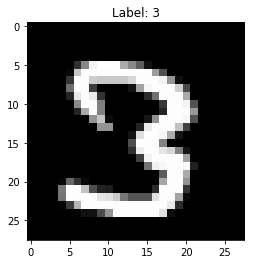

In [75]:
# example
X, label = next(iter(trainloader))
plt.imshow(X[0, 0].numpy(), 'gray');
plt.title(f'Label: {str(label[0].numpy())}');

In [76]:
import torch.nn.functional as F

def train_and_display(model, dataloader):
    num_epochs = 1
    learning_rate = 0.01
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    total_step = len(dataloader)
    acc_list = []
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(dataloader):
            outputs = model(inputs)
            if i == 0:
                plt.figure(figsize=[2,2])
                plt.imshow(inputs[0, 0].numpy(), 'gray');
                
                pred = outputs.argmax(dim=1, keepdim=True)
                correct = pred.eq(labels.view_as(pred)).sum().item()
                prediction = pred[0].numpy()[0]
                plt.title(f'Label: {str(label[0].numpy())} Pred: {str(prediction)}');
                plt.show()                
                
            loss = F.nll_loss(outputs, labels)
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    plt.figure(figsize=[2,2])
    plt.imshow(inputs[0, 0].numpy(), 'gray');

    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).sum().item()
    prediction = pred[0].numpy()[0]
    plt.title(f'Label: {str(label[0].numpy())} Pred: {str(prediction)}');
    plt.show()

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


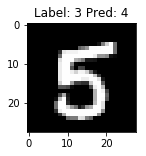

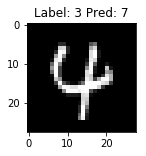

In [77]:
# try it
train_and_display(model, trainloader)